# Lab 5- Deep Learning Model

This lab is meant to get you started in using Keras to design Deep Neural Networks. The goal here is to simply repeat Lab 4, but with DNNs.

Let's start with reading the data, like before:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

filename="/data/afarbin/DLClass/SUSY/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi"]
FeatureNames=[ "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

df = pd.read_csv(filename, dtype='float64', names=VarNames)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.


Now lets define training and test samples. Note that DNNs take very long to train, so for testing purposes we will use only about 10% of the 5 million events in the training/validation sample. Once you get everything working, make the final version of your plots with the full sample. 

Also note that Keras had trouble with the Pandas tensors, so after doing all of the nice manipulation that Pandas enables, we convert the Tensor to a regular numpy tensor.

In [2]:
N_Max=550000
N_Train=500000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:N_Max]

X_Train=np.array(Train_Sample[VarNames[1:]])
y_Train=np.array(Train_Sample["signal"])

X_Test=np.array(Test_Sample[VarNames[1:]])
y_Test=np.array(Test_Sample["signal"])


Now lets setup everything. Note that you will need to use a GPU to get reasonable training times. The Jupyter server will have up tp 4 GPUs in it. Your Jupyter session is now running through a batch queue system that effectively assigns a GPU to you. Here we tell Keras's backend, Theano, to use the GPU assigned to you.

In [3]:
import os 
print "Using Queue:", os.environ["PBS_QUEUE"]
gpuid=int(os.environ["PBS_QUEUE"][3:4])
print "Using GPU:", gpuid
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=gpu%s,floatX=float32,force_device=True" % (gpuid)

Using Queue: gpu7theco_ipynb
Using GPU: 7


There was some problem getting the profiler to work in this notebook, so we turn it off: 

In [4]:
import theano
theano.config.profile=False

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 7: TITAN X (Pascal) (CNMeM is disabled, cuDNN 7103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:631: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn(warn)


Exception: The nvidia driver version installed with this OS does not give good results for reduction.Installing the nvidia driver available on the same download page as the cuda package will fix the problem: http://developer.nvidia.com/cuda-downloads

Now we will build a simple model, as described in class. Note that this is very small model, so things run fast. You should attempt more ambitious models.

In [5]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim=X_Train.shape[1], init='uniform', activation='relu'))
model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="relu", kernel_initializer="uniform", input_dim=18)`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  import sys


The model has to be compiled. At this time we set the loss function and the optimizer too:

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


Now we train. We are running only 10 epochs in this example. Models may need hundreds of epochs before they stop improving.

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
history=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=10, batch_size=2048)

Train on 500000 samples, validate on 50000 samples
Epoch 1/10
500000/500000 [==============================] - 2s - loss: 0.5906 - acc: 0.6874 - val_loss: 0.4692 - val_acc: 0.7865
Epoch 2/10
500000/500000 [==============================] - 1s - loss: 0.4556 - acc: 0.7922 - val_loss: 0.4550 - val_acc: 0.7909
Epoch 3/10
500000/500000 [==============================] - 2s - loss: 0.4491 - acc: 0.7947 - val_loss: 0.4511 - val_acc: 0.7907
Epoch 4/10
500000/500000 [==============================] - 2s - loss: 0.4457 - acc: 0.7958 - val_loss: 0.4481 - val_acc: 0.7928
Epoch 5/10
500000/500000 [==============================] - 2s - loss: 0.4432 - acc: 0.7966 - val_loss: 0.4462 - val_acc: 0.7932
Epoch 6/10
500000/500000 [==============================] - 1s - loss: 0.4418 - acc: 0.7970 - val_loss: 0.4442 - val_acc: 0.7946
Epoch 7/10
500000/500000 [==============================] - 2s - loss: 0.4404 - acc: 0.7977 - val_loss: 0.4431 - val_acc: 0.7940
Epoch 8/10
500000/500000 [====================

The model history keeps track of the loss and accuracy for each epoch. Note that the training above was setup to run on the validation sample at the end of each epoch:

In [8]:
print history.history

{'acc': [0.687416, 0.7922279999961853, 0.7947099999923706, 0.7957920000038147, 0.7966139999847413, 0.7969699999885559, 0.7976579999961853, 0.797924, 0.7983219999885559, 0.7981819999923706], 'loss': [0.5905892027015686, 0.45559755587387085, 0.4490501797084808, 0.4457262751903534, 0.4432289777393341, 0.4418368912200928, 0.44041521991920474, 0.439462115732193, 0.4388597562351227, 0.43813303862762454], 'val_acc': [0.786480000038147, 0.7908799997711181, 0.7906800002288819, 0.7927600001335144, 0.7931999996757507, 0.7946000001335144, 0.7940200003242492, 0.7946600002288818, 0.7952000001335144, 0.7943400004196167], 'val_loss': [0.46919239765167237, 0.4550112501335144, 0.4510858226490021, 0.448099481716156, 0.44616716861724853, 0.444165364522934, 0.4430972048282623, 0.44207669350624085, 0.44112973915100095, 0.4421688135433197]}


## Exercise 5.1

You will need to create several models and make sure they are properly trained. Write a function that takes this history and plots the values versus epoch. For every model that you train in the remainder of this lab, assess:

    * Has you model's performance plateaued? If not train for more epochs. 

    * Compare the performance on training versus test sample. Are you over training?

Train on 500000 samples, validate on 50000 samples
Epoch 1/100
500000/500000 [==============================] - 2s - loss: 0.4377 - acc: 0.7986 - val_loss: 0.4400 - val_acc: 0.7956
Epoch 2/100
500000/500000 [==============================] - 2s - loss: 0.4375 - acc: 0.7987 - val_loss: 0.4400 - val_acc: 0.7953
Epoch 3/100
500000/500000 [==============================] - 1s - loss: 0.4369 - acc: 0.7988 - val_loss: 0.4396 - val_acc: 0.7964
Epoch 4/100
500000/500000 [==============================] - 2s - loss: 0.4367 - acc: 0.7989 - val_loss: 0.4393 - val_acc: 0.7960
Epoch 5/100
500000/500000 [==============================] - 2s - loss: 0.4366 - acc: 0.7988 - val_loss: 0.4389 - val_acc: 0.7963
Epoch 6/100
500000/500000 [==============================] - 2s - loss: 0.4367 - acc: 0.7989 - val_loss: 0.4388 - val_acc: 0.7957
Epoch 7/100
500000/500000 [==============================] - 2s - loss: 0.4362 - acc: 0.7990 - val_loss: 0.4387 - val_acc: 0.7966
Epoch 8/100
500000/500000 [============

500000/500000 [==============================] - 2s - loss: 0.4340 - acc: 0.7998 - val_loss: 0.4364 - val_acc: 0.7966
Epoch 64/100
500000/500000 [==============================] - 2s - loss: 0.4339 - acc: 0.7999 - val_loss: 0.4360 - val_acc: 0.7974
Epoch 65/100
500000/500000 [==============================] - 2s - loss: 0.4339 - acc: 0.7999 - val_loss: 0.4359 - val_acc: 0.7972
Epoch 66/100
500000/500000 [==============================] - 2s - loss: 0.4338 - acc: 0.7999 - val_loss: 0.4372 - val_acc: 0.7960
Epoch 67/100
500000/500000 [==============================] - 2s - loss: 0.4338 - acc: 0.8000 - val_loss: 0.4361 - val_acc: 0.7974
Epoch 68/100
500000/500000 [==============================] - 2s - loss: 0.4337 - acc: 0.7998 - val_loss: 0.4361 - val_acc: 0.7968
Epoch 69/100
500000/500000 [==============================] - 2s - loss: 0.4338 - acc: 0.7997 - val_loss: 0.4358 - val_acc: 0.7974
Epoch 70/100
500000/500000 [==============================] - 2s - loss: 0.4337 - acc: 0.8002 - 

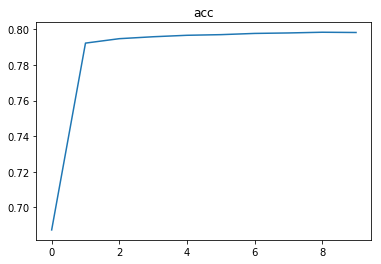

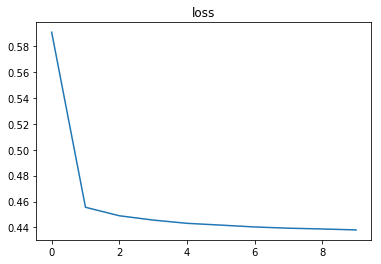

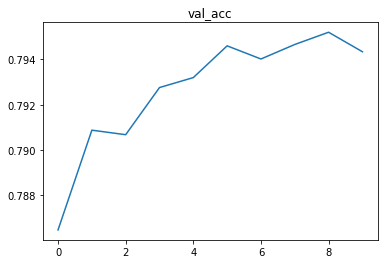

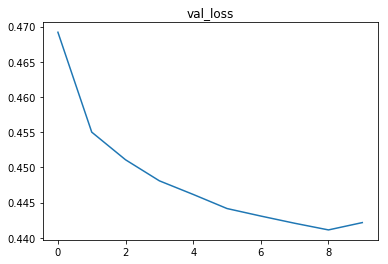

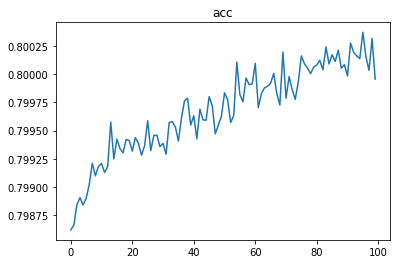

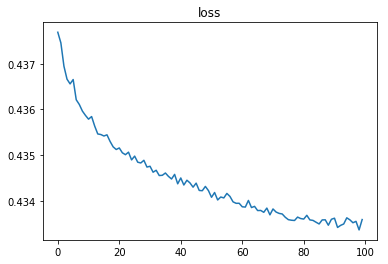

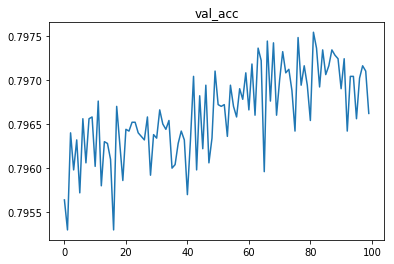

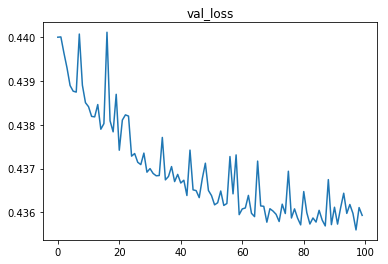

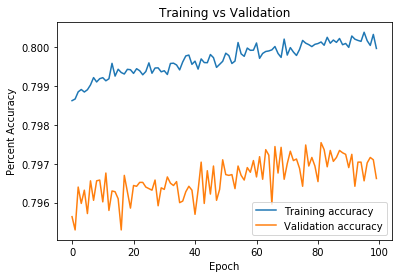

"\nI don't think I'm overfitting the accuracy of the training and the validation data rise about the same.\nIt might be overfitting if the training set did significantly better than the validation set\n"

In [9]:
## Your Solution Here
def plot_hist(history_dict):
    for var in history_dict.keys():
        plt.title(var)
        plt.plot(range(0, len(history_dict["acc"])), history_dict[var])
        plt.show()

history_2=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=100, batch_size=2048)
print history_2.history

plot_hist(history.history)
plot_hist(history_2.history)

"""
After looking at the performance of the two graphs, it seems that the performance is plateaued since the accuracy
after 10 epochs is around 80%, similar to the accuracy after 100 epochs
"""


plt.title("Training vs Validation")
plt.plot(range(0, len(history_2.history["acc"])), history_2.history["acc"], label="Training accuracy")
plt.plot(range(0, len(history_2.history["val_acc"])), history_2.history["val_acc"], label="Validation accuracy")
plt.legend(loc="lower right")
plt.xlabel('Epoch')
plt.ylabel('Percent Accuracy')
plt.show()

"""
I don't think I'm overfitting the accuracy of the training and the validation data rise about the same.
It might be overfitting if the training set did significantly better than the validation set
"""

We can evaluate how the trained model does on the test sample as follows:

In [10]:
scores = model.evaluate(X_Test, y_Test)
print scores

49600/50000 [============================>.] - ETA: 0s[0.43593023630142214, 0.79662]


And we can make ROC curves as before:

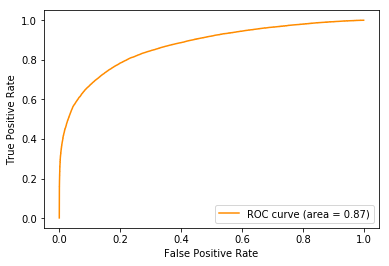

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, model.predict(X_Test))
                        
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## Exercise 5.2

Following lab 4, make a comparison of the performance between models trained with raw, features, and raw+features data.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="relu", kernel_initializer="uniform", input_dim=6)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________
Train on 500000 samples, validate on 50000 samples
Epoch 1/20
500000/500000 [==============================] - 2s - loss: 0.6329 - acc: 0.6672 - val_loss: 0.5679 - val_acc: 0.7178
Epoch 2/20
500000/500000 [==============================] - 2s - loss: 0.5620 - acc: 0.7175 - val_loss: 0.5592 - val_acc: 0.7181
Epoch 3/20
500000/500000 [==============================] - 1s - loss: 0.5573 - acc: 0.7198 - val_l

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="relu", kernel_initializer="uniform", input_dim=12)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


Train on 500000 samples, validate on 50000 samples
Epoch 1/20
500000/500000 [==============================] - 2s - loss: 0.5806 - acc: 0.7154 - val_loss: 0.4822 - val_acc: 0.7745
Epoch 2/20
500000/500000 [==============================] - 1s - loss: 0.4729 - acc: 0.7786 - val_loss: 0.4746 - val_acc: 0.7778
Epoch 3/20
500000/500000 [==============================] - 2s - loss: 0.4687 - acc: 0.7811 - val_loss: 0.4707 - val_acc: 0.7793
Epoch 4/20
500000/500000 [==============================] - 2s - loss: 0.4650 - acc: 0.7816 - val_loss: 0.4673 - val_acc: 0.7797
Epoch 5/20
500000/500000 [==============================] - 1s - loss: 0.4628 - acc: 0.7824 - val_loss: 0.4657 - val_acc: 0.7796
Epoch 6/20
500000/500000 [==============================] - 1s - loss: 0.4616 - acc: 0.7827 - val_loss: 0.4650 - val_acc: 0.7794
Epoch 7/20
500000/500000 [==============================] - 1s - loss: 0.4611 - acc: 0.7832 - val_loss: 0.4644 - val_acc: 0.7792
Epoch 8/20
500000/500000 [====================

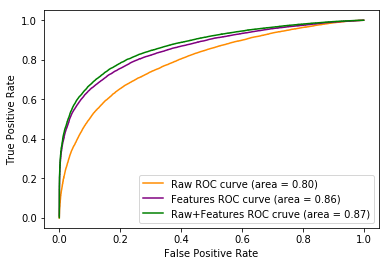

In [12]:
## Your solution here

rawTrain=np.array(Train_Sample[RawNames])
rawYTrain=np.array(Train_Sample["signal"])
rawTest=np.array(Test_Sample[RawNames])
rawYTest=np.array(Test_Sample["signal"])
rawModel=Sequential()
rawModel.add(Dense(12, input_dim=rawTrain.shape[1], init='uniform', activation='relu'))
rawModel.add(Dense(8, init='uniform', activation='relu'))
rawModel.add(Dense(1, init='uniform', activation='sigmoid'))
rawModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rawModel.summary()
rawHistory=rawModel.fit(rawTrain, rawYTrain, validation_data=(rawTest, rawYTest), epochs=20, batch_size=2048)

featureTrain=np.array(Train_Sample[FeatureNames])
featureYTrain=np.array(Train_Sample["signal"])
featureTest=np.array(Test_Sample[FeatureNames])
featureYTest=np.array(Test_Sample["signal"])
featureModel=Sequential()
featureModel.add(Dense(12, input_dim=featureTrain.shape[1], init='uniform', activation='relu'))
featureModel.add(Dense(8, init='uniform', activation='relu'))
featureModel.add(Dense(1, init='uniform', activation='sigmoid'))
featureModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
featureModel.summary()
featureHistory=featureModel.fit(featureTrain, featureYTrain, validation_data=(featureTest, featureYTest), epochs=20, batch_size=2048)

allHistory=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=20, batch_size=2048)

fprRaw, tprRaw, _ = roc_curve(rawYTest, rawModel.predict(rawTest))                        
roc_auc_raw = auc(fprRaw, tprRaw)
fprFeature, tprFeature, _ = roc_curve(featureYTest, featureModel.predict(featureTest))
roc_auc_feature = auc(fprFeature, tprFeature)
fprAll, tprAll, _ = roc_curve(y_Test, model.predict(X_Test))
roc_auc_all = auc(fprAll, tprAll)

plt.plot(fprRaw,tprRaw,color='darkorange',label='Raw ROC curve (area = %0.2f)' % roc_auc_raw)
plt.plot(fprFeature, tprFeature, color='purple',label='Features ROC curve (area = %0.2f)' % roc_auc_feature)
plt.plot(fprAll, tprAll, color='green',label='Raw+Features ROC cruve (area = %0.2f)' % roc_auc_all)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Exercise 5.3

Again, following lab 4, design and implement at least 3 different DNN models. Train them and compare performance. You may try different architectures, loss functions, and optimizers to see if there is an effect.

In [26]:
## Your solution here
from keras import optimizers
############# Raw Variables' Comparison ##################
model_1 = Sequential()
model_1.add(Dense(32, input_dim=rawTrain.shape[1], init='uniform', activation='relu'))
model_1.add(Dense(16, init='uniform', activation='relu'))
model_1.add(Dense(1, init='uniform', activation='sigmoid'))
sgd = optimizers.SGD(lr=0.01)
model_1.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['accuracy'])
model_1.summary()
model_1_history=model_1.fit(rawTrain, rawYTrain, validation_data=(rawTest, rawYTest), epochs=30, batch_size=2048)

model_2 = Sequential()
model_2.add(Dense(32, input_dim=rawTrain.shape[1], init='uniform', activation='relu'))
model_2.add(Dense(16, init='uniform', activation='relu'))
model_2.add(Dense(8, init='uniform', activation='relu'))
model_2.add(Dense(1, init='uniform', activation='sigmoid'))
RMSProp = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model_2.compile(loss='mean_squared_error', optimizer=RMSProp, metrics=['accuracy'])
model_2.summary()
model_2_history=model_2.fit(rawTrain, rawYTrain, validation_data=(rawTest, rawYTest), epochs=30, batch_size=2048)

model_3 = Sequential()
model_3.add(Dense(32, input_dim=rawTrain.shape[1], init='uniform', activation='relu'))
model_3.add(Dense(16, init='uniform', activation='relu'))
model_3.add(Dense(8, init='uniform', activation='relu'))
model_3.add(Dense(1, init='uniform', activation='sigmoid'))
Nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model_3.compile(loss='mean_squared_error', optimizer=Nadam, metrics=['accuracy'])
model_3.summary()
model_3_history=model_3.fit(rawTrain, rawYTrain, validation_data=(rawTest, rawYTest), epochs=30, batch_size=2048)

fpr_1_Raw, tpr_1_Raw, _ = roc_curve(rawYTest, model_1.predict(rawTest))                        
roc_auc_1_raw = auc(fpr_1_Raw, tpr_1_Raw)
fpr_2_Raw, tpr_2_Raw, _ = roc_curve(rawYTest, model_2.predict(rawTest))                        
roc_auc_2_raw = auc(fpr_2_Raw, tpr_2_Raw)
fpr_3_Raw, tpr_3_Raw, _ = roc_curve(rawYTest, model_3.predict(rawTest))                        
roc_auc_3_raw = auc(fpr_3_Raw, tpr_3_Raw)

plt.title("Raw Variables' Performance")
plt.plot(fpr_1_Raw, tpr_1_Raw, color='darkorange', label='Raw Model 1 ROC Cruve (area=%0.2f)' % roc_auc_1_raw)
plt.plot(fpr_2_Raw, tpr_2_Raw, color='purple', label='Raw Model 2 ROC Cruve (area=%0.2f)' % roc_auc_2_raw)
plt.plot(fpr_3_Raw, tpr_3_Raw, color='green', label='Raw Model 3 ROC Cruve (area=%0.2f)' % roc_auc_3_raw)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

##############################################################

############# Feature Variables' Comparison ##################
model_1 = Sequential()
model_1.add(Dense(32, input_dim=featureTrain.shape[1], init='uniform', activation='relu'))
model_1.add(Dense(16, init='uniform', activation='relu'))
model_1.add(Dense(1, init='uniform', activation='sigmoid'))
sgd = optimizers.SGD(lr=0.01)
model_1.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['accuracy'])
model_1.summary()
model_1_history=model_1.fit(featureTrain, featureYTrain, validation_data=(featureTest, featureYTest), epochs=30, batch_size=2048)

model_2 = Sequential()
model_2.add(Dense(32, input_dim=featureTrain.shape[1], init='uniform', activation='relu'))
model_2.add(Dense(16, init='uniform', activation='relu'))
model_2.add(Dense(8, init='uniform', activation='relu'))
model_2.add(Dense(1, init='uniform', activation='sigmoid'))
RMSProp = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model_2.compile(loss='mean_squared_error', optimizer=RMSProp, metrics=['accuracy'])
model_2.summary()
model_2_history=model_2.fit(featureTrain, featureYTrain, validation_data=(featureTest, featureYTest), epochs=30, batch_size=2048)

model_3 = Sequential()
model_3.add(Dense(32, input_dim=featureTrain.shape[1], init='uniform', activation='relu'))
model_3.add(Dense(16, init='uniform', activation='relu'))
model_3.add(Dense(8, init='uniform', activation='relu'))
model_3.add(Dense(1, init='uniform', activation='sigmoid'))
Nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model_3.compile(loss='mean_squared_error', optimizer=Nadam, metrics=['accuracy'])
model_3.summary()
model_3_history=model_3.fit(featureTrain, featureYTrain, validation_data=(featureTest, featureYTest), epochs=30, batch_size=2048)

fpr_1_Feature, tpr_1_Feature, _ = roc_curve(featureYTest, model_1.predict(featureTest))                        
roc_auc_1_feature = auc(fpr_1_Feature, tpr_1_Feature)
fpr_2_Feature, tpr_2_Feature, _ = roc_curve(featureYTest, model_2.predict(featureTest))                        
roc_auc_2_feature = auc(fpr_2_Feature, tpr_2_Feature)
fpr_3_Feature, tpr_3_Feature, _ = roc_curve(featureYTest, model_3.predict(featureTest))                        
roc_auc_3_feature = auc(fpr_3_Feature, tpr_3_Feature)

plt.title("Feature Variables' Performance")
plt.plot(fpr_1_Feature, tpr_1_Feature, color='darkorange', label='Feature Model 1 ROC Cruve (area=%0.2f)' % roc_auc_1_feature)
plt.plot(fpr_2_Feature, tpr_2_Feature, color='purple', label='Feature Model 2 ROC Cruve (area=%0.2f)' % roc_auc_2_feature)
plt.plot(fpr_3_Feature, tpr_3_Feature, color='green', label='Feature Model 3 ROC Cruve (area=%0.2f)' % roc_auc_3_feature)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
##############################################################

############# All Variables' Comparison ##################
model_1 = Sequential()
model_1.add(Dense(32, input_dim=X_Train.shape[1], init='uniform', activation='relu'))
model_1.add(Dense(16, init='uniform', activation='relu'))
model_1.add(Dense(1, init='uniform', activation='sigmoid'))
sgd = optimizers.SGD(lr=0.01)
model_1.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['accuracy'])
model_1.summary()
model_1_history=model_1.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=30, batch_size=2048)

model_2 = Sequential()
model_2.add(Dense(32, input_dim=X_Train.shape[1], init='uniform', activation='relu'))
model_2.add(Dense(16, init='uniform', activation='relu'))
model_2.add(Dense(8, init='uniform', activation='relu'))
model_2.add(Dense(1, init='uniform', activation='sigmoid'))
RMSProp = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model_2.compile(loss='mean_squared_error', optimizer=RMSProp, metrics=['accuracy'])
model_2.summary()
model_2_history=model_2.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=30, batch_size=2048)

model_3 = Sequential()
model_3.add(Dense(32, input_dim=X_Train.shape[1], init='uniform', activation='relu'))
model_3.add(Dense(16, init='uniform', activation='relu'))
model_3.add(Dense(8, init='uniform', activation='relu'))
model_3.add(Dense(1, init='uniform', activation='sigmoid'))
Nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model_3.compile(loss='mean_squared_error', optimizer=Nadam, metrics=['accuracy'])
model_3.summary()
model_3_history=model_3.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=30, batch_size=2048)

fpr_1_All, tpr_1_All, _ = roc_curve(y_Test, model_1.predict(X_Test))                        
roc_auc_1_all = auc(fpr_1_All, tpr_1_All)
fpr_2_All, tpr_2_All, _ = roc_curve(y_Test, model_2.predict(X_Test))                        
roc_auc_2_all = auc(fpr_2_All, tpr_2_All)
fpr_3_All, tpr_3_All, _ = roc_curve(y_Test, model_3.predict(X_Test))                        
roc_auc_3_all = auc(fpr_3_All, tpr_3_All)

plt.title("All Variables' Performance")
plt.plot(fpr_1_All, tpr_1_All, color='darkorange', label='All Model 1 ROC Cruve (area=%0.2f)' % roc_auc_1_all)
plt.plot(fpr_2_All, tpr_2_All, color='purple', label='All Model 2 ROC Cruve (area=%0.2f)' % roc_auc_2_all)
plt.plot(fpr_3_All, tpr_3_All, color='green', label='All Model 3 ROC Cruve (area=%0.2f)' % roc_auc_3_all)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
##############################################################

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform", input_dim=6)`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 32)                224       
_________________________________________________________________
dense_98 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Train on 500000 samples, validate on 50000 samples
Epoch 1/30
500000/500000 [==============================] - 2s - loss: 0.4995 - acc: 0.5418 - val_loss: 0.4990 - val_acc: 0.5399
Epoch 2/30
500000/500000 [==============================] - 1s - loss: 0.4984 - acc: 0.5415 - val_loss: 0.4980 - val_acc: 0.5399
Epoch 3/30
500000/500000 [==============================] - 1s - loss: 0.4973 - acc: 0.5415 - val_l

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform", input_dim=12)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


Train on 500000 samples, validate on 50000 samples
Epoch 1/30
500000/500000 [==============================] - 2s - loss: 0.4995 - acc: 0.5415 - val_loss: 0.4990 - val_acc: 0.5399
Epoch 2/30
500000/500000 [==============================] - 1s - loss: 0.4984 - acc: 0.5415 - val_loss: 0.4980 - val_acc: 0.5399
Epoch 3/30
500000/500000 [==============================] - 1s - loss: 0.4974 - acc: 0.5415 - val_loss: 0.4970 - val_acc: 0.5399
Epoch 4/30
500000/500000 [==============================] - 1s - loss: 0.4963 - acc: 0.5415 - val_loss: 0.4960 - val_acc: 0.5399
Epoch 5/30
500000/500000 [==============================] - 1s - loss: 0.4953 - acc: 0.5415 - val_loss: 0.4949 - val_acc: 0.5399
Epoch 6/30
500000/500000 [==============================] - 1s - loss: 0.4942 - acc: 0.5415 - val_loss: 0.4940 - val_acc: 0.5399
Epoch 7/30
500000/500000 [==============================] - 1s - loss: 0.4932 - acc: 0.5415 - val_loss: 0.4930 - val_acc: 0.5399
Epoch 8/30
500000/500000 [====================

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform", input_dim=12)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:73: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


ValueError: None values not supported.

## Honors Problem- Exercise 5.4

Write a function that evaluates the performance (AUC) as a function of a given input variable. You will need to bin the test data in the variable (i.e. make sub-samples for events which have the particular variable in a range), evaluate the performance in each bin, and plot the results.

Apply your function to each input variable.